# Greeks Validdation Notebook
This notebook is used to calcute and evlaute greek option prices and statistics

## Key Activaties
    1. Load interim data
    2. Calculate greek prices and statistics
    3. Generate charts and plots and save to reports folder
    3. Ensure Data Quanlty and save to final folder (processed folder) for the final notebook

In [22]:
import sys, os

# Get the project root directory (one level up from notebooks folder)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# Add both project root and src to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"Project root: {project_root}")
print(f"Source path: {src_path}")
print(f"Python path updated successfully!")

Project root: /workspaces/Systematic-Options-Auto-Hedging-Engine
Source path: /workspaces/Systematic-Options-Auto-Hedging-Engine/src
Python path updated successfully!


In [23]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import yaml
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.1
NumPy version: 2.3.1


In [24]:
# Import Greek calculation modules
try:
    from greeks.black_scholes import black_scholes_call, black_scholes_put, gamma, vega, theta, rho, Summary
    from greeks.heston import heston_price, heston_delta, heston_gamma, heston_vega, heston_theta
    print("✓ Successfully imported Greek calculation modules")
except ImportError as e:
    print(f"✗ Failed to import Greek modules: {e}")
    print("Available paths:")
    for path in sys.path[:3]:
        print(f"  {path}")
    raise

✓ Successfully imported Greek calculation modules


## 1. Load Configuration Files
Load model parameters from Black-Scholes and Heston configuration files

In [25]:
# Load configuration files
def load_config(config_path):
    """Load YAML configuration file"""
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

# Load Black-Scholes and Heston model configurations
bs_config_path = os.path.join(project_root, "configs", "model.black_scholes.yaml")
heston_config_path = os.path.join(project_root, "configs", "model.heston.yaml")

bs_config = load_config(bs_config_path)
heston_config = load_config(heston_config_path)

print("Configuration files loaded successfully!")
print(f"Black-Scholes config: {bs_config}")
print(f"Heston config: {heston_config}")

# Extract parameters for easy access
bs_params = {
    'risk_free_rate': 0.05,
    'volatility': 0.2,
    'dividend_yield': 0.01
}

heston_params = {
    'risk_free_rate': 0.05,
    'initial_volatility': 0.2,
    'dividend_yield': 0.01,
    'kappa': 2.0,        # Mean reversion speed
    'theta': 0.04,       # Long-term variance
    'sigma': 0.3,        # Volatility of variance
    'rho': -0.7          # Correlation between price and variance
}

print("\nExtracted parameters:")
print(f"Black-Scholes: {bs_params}")
print(f"Heston: {heston_params}")

Configuration files loaded successfully!
Black-Scholes config: {'model': {'type': 'black_scholes_put', 'parameters': {'risk_free_rate': 0.05, 'volatility': 0.2, 'dividend_yield': 0.01, 'option_type': 'put'}}}
Heston config: {'model': {'type': 'heston_put', 'parameters': {'risk_free_rate': 0.05, 'volatility': 0.2, 'dividend_yield': 0.01, 'option_type': 'put'}}}

Extracted parameters:
Black-Scholes: {'risk_free_rate': 0.05, 'volatility': 0.2, 'dividend_yield': 0.01}
Heston: {'risk_free_rate': 0.05, 'initial_volatility': 0.2, 'dividend_yield': 0.01, 'kappa': 2.0, 'theta': 0.04, 'sigma': 0.3, 'rho': -0.7}


## 2. Load Interim Data
Load the processed stock data from the first notebook

In [26]:
# Load interim data from the first notebook
interim_dir = os.path.join(project_root, "data", "interim")
print(f"Loading data from: {interim_dir}")

# Find available data files
import glob
data_files = glob.glob(os.path.join(interim_dir, "*_processed_*.csv"))
print(f"Found {len(data_files)} processed data files:")
for file in data_files:
    print(f"  - {os.path.basename(file)}")

# Load the data
stock_data = {}
if data_files:
    for file_path in data_files:
        # Extract ticker from filename
        filename = os.path.basename(file_path)
        ticker = filename.split('_')[0]
        
        # Load the data
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        stock_data[ticker] = df
        print(f"✓ Loaded {ticker}: {df.shape[0]} records from {df.index.min()} to {df.index.max()}")
else:
    print("No processed data files found. Creating sample data for demonstration...")
    # Create sample data for demonstration
    dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
    np.random.seed(42)
    
    for ticker in ['AAPL', 'MSFT', 'GOOGL']:
        # Generate sample price data
        returns = np.random.normal(0.001, 0.02, len(dates))
        prices = 100 * np.exp(np.cumsum(returns))
        
        df = pd.DataFrame({
            'close': prices,
            'daily_return': np.concatenate([[np.nan], np.diff(np.log(prices))]),
            'volatility_20': pd.Series(returns).rolling(20).std() * np.sqrt(252)
        }, index=dates)
        
        stock_data[ticker] = df.dropna()
        print(f"✓ Created sample data for {ticker}: {len(df)} records")

print(f"\nLoaded data for {len(stock_data)} stocks: {list(stock_data.keys())}")

Loading data from: /workspaces/Systematic-Options-Auto-Hedging-Engine/data/interim
Found 5 processed data files:
  - MSFT_processed_20251001.csv
  - AMZN_processed_20251001.csv
  - TSLA_processed_20251001.csv
  - GOOGL_processed_20251001.csv
  - AAPL_processed_20251001.csv
✓ Loaded MSFT: 1006 records from 2020-01-02 00:00:00 to 2023-12-29 00:00:00
✓ Loaded AMZN: 1006 records from 2020-01-02 00:00:00 to 2023-12-29 00:00:00
✓ Loaded TSLA: 1006 records from 2020-01-02 00:00:00 to 2023-12-29 00:00:00
✓ Loaded GOOGL: 1006 records from 2020-01-02 00:00:00 to 2023-12-29 00:00:00
✓ Loaded AAPL: 1006 records from 2020-01-02 00:00:00 to 2023-12-29 00:00:00

Loaded data for 5 stocks: ['MSFT', 'AMZN', 'TSLA', 'GOOGL', 'AAPL']


## 3. Calculate Option Greeks
Calculate Greeks using both Black-Scholes and Heston models for validation

In [27]:
# Define option parameters for Greeks calculation
option_params = {
    'strikes': [90, 95, 100, 105, 110],  # Strike prices relative to spot
    'expiries': [0.25, 0.5, 1.0],       # Time to expiry in years (3m, 6m, 1y)
    'option_types': ['call', 'put']
}

print("Option parameters for Greeks calculation:")
print(f"Strike prices (relative): {option_params['strikes']}")
print(f"Time to expiry: {option_params['expiries']} years")
print(f"Option types: {option_params['option_types']}")

# Calculate Greeks for each stock
greeks_results = {}

for ticker, df in stock_data.items():
    print(f"\nCalculating Greeks for {ticker}...")
    
    # Use recent data for current spot price and volatility
    recent_data = df.tail(100)  # Last 100 days
    current_spot = recent_data['close'].iloc[-1]
    current_vol = recent_data['volatility_20'].iloc[-1]
    
    if pd.isna(current_vol):
        current_vol = bs_params['volatility']  # Use default if NaN
    
    print(f"  Current spot price: ${current_spot:.2f}")
    print(f"  Current volatility: {current_vol:.4f}")
    
    ticker_results = {
        'spot_price': current_spot,
        'volatility': current_vol,
        'black_scholes': {},
        'heston': {}
    }
    
    # Calculate for each strike and expiry combination
    for strike_ratio in option_params['strikes']:
        for expiry in option_params['expiries']:
            for option_type in option_params['option_types']:
                
                strike = current_spot * (strike_ratio / 100)
                
                # Black-Scholes Greeks
                try:
                    key = f"{option_type}_{strike_ratio}_{expiry}"
                    
                    # Calculate price
                    if option_type == 'call':
                        bs_price = black_scholes_call(current_spot, strike, expiry, 
                                                    bs_params['risk_free_rate'], current_vol)
                    else:
                        bs_price = black_scholes_put(current_spot, strike, expiry, 
                                                   bs_params['risk_free_rate'], current_vol)
                    
                    # Calculate Greeks
                    import scipy.stats as si
                    d1 = (np.log(current_spot/strike) + (bs_params['risk_free_rate'] + 0.5*current_vol**2)*expiry)/(current_vol*np.sqrt(expiry))
                    bs_delta = si.norm.cdf(d1) if option_type == 'call' else si.norm.cdf(d1) - 1
                    bs_gamma = gamma(current_spot, strike, expiry, bs_params['risk_free_rate'], current_vol)
                    bs_theta = theta(current_spot, strike, expiry, bs_params['risk_free_rate'], current_vol, option_type)
                    bs_vega = vega(current_spot, strike, expiry, bs_params['risk_free_rate'], current_vol)
                    bs_rho = rho(current_spot, strike, expiry, bs_params['risk_free_rate'], current_vol, option_type)
                    ticker_results['black_scholes'][key] = {
                        'strike': strike,
                        'expiry': expiry,
                        'type': option_type,
                        'price': bs_price,
                        'delta': bs_delta,
                        'gamma': bs_gamma,
                        'theta': bs_theta,
                        'vega': bs_vega,
                        'rho': bs_rho
                    }
                    
                except Exception as e:
                    print(f"    ✗ Black-Scholes failed for {key}: {e}")
                
                # Heston Greeks
                try:
                    heston_greeks_result = heston_greeks(
                        S=current_spot,
                        K=strike,
                        T=expiry,
                        r=heston_params['risk_free_rate'],
                        q=heston_params['dividend_yield'],
                        v0=heston_params['initial_volatility']**2,  # Convert to variance
                        kappa=heston_params['kappa'],
                        theta=heston_params['theta'],
                        sigma=heston_params['sigma'],
                        rho=heston_params['rho']
                    )
                    
                    key = f"{option_type}_{strike_ratio}_{expiry}"
                    ticker_results['heston'][key] = {
                        'strike': strike,
                        'expiry': expiry,
                        'type': option_type,
                        'delta': heston_greeks_result['delta'],
                        'gamma': heston_greeks_result['gamma'],
                        'theta': heston_greeks_result['theta'],
                        'vega': heston_greeks_result['vega'],
                        'rho': heston_greeks_result['rho']
                    }
                    
                except Exception as e:
                    print(f"    ✗ Heston failed for {key}: {e}")
    
    greeks_results[ticker] = ticker_results
    print(f"  ✓ Completed Greeks calculation for {ticker}")

print(f"\nGreeks calculated for {len(greeks_results)} stocks")

Option parameters for Greeks calculation:
Strike prices (relative): [90, 95, 100, 105, 110]
Time to expiry: [0.25, 0.5, 1.0] years
Option types: ['call', 'put']

Calculating Greeks for MSFT...
  Current spot price: $376.04
  Current volatility: 0.1462
    ✗ Heston failed for call_90_0.25: name 'heston_greeks' is not defined
    ✗ Heston failed for put_90_0.25: name 'heston_greeks' is not defined
    ✗ Heston failed for call_90_0.5: name 'heston_greeks' is not defined
    ✗ Heston failed for put_90_0.5: name 'heston_greeks' is not defined
    ✗ Heston failed for call_90_1.0: name 'heston_greeks' is not defined
    ✗ Heston failed for put_90_1.0: name 'heston_greeks' is not defined
    ✗ Heston failed for call_95_0.25: name 'heston_greeks' is not defined
    ✗ Heston failed for put_95_0.25: name 'heston_greeks' is not defined
    ✗ Heston failed for call_95_0.5: name 'heston_greeks' is not defined
    ✗ Heston failed for put_95_0.5: name 'heston_greeks' is not defined
    ✗ Heston failed

## 4. Greeks Analysis and Validation
Analyze the calculated Greeks and compare between models

In [28]:
# Create comprehensive DataFrame for analysis
def create_greeks_dataframe(greeks_results):
    """Convert Greeks results to DataFrame for analysis"""
    all_data = []
    
    for ticker, ticker_data in greeks_results.items():
        spot_price = ticker_data['spot_price']
        volatility = ticker_data['volatility']
        
        # Process Black-Scholes results
        for key, greeks in ticker_data['black_scholes'].items():
            option_type, strike_ratio, expiry = key.split('_')
            all_data.append({
                'ticker': ticker,
                'model': 'Black-Scholes',
                'option_type': option_type,
                'strike_ratio': int(strike_ratio),
                'expiry': float(expiry),
                'spot_price': spot_price,
                'strike_price': greeks['strike'],
                'volatility': volatility,
                'delta': greeks['delta'],
                'gamma': greeks['gamma'],
                'theta': greeks['theta'],
                'vega': greeks['vega'],
                'rho': greeks['rho'],
                'moneyness': spot_price / greeks['strike']
            })
        
        # Process Heston results
        for key, greeks in ticker_data['heston'].items():
            option_type, strike_ratio, expiry = key.split('_')
            all_data.append({
                'ticker': ticker,
                'model': 'Heston',
                'option_type': option_type,
                'strike_ratio': int(strike_ratio),
                'expiry': float(expiry),
                'spot_price': spot_price,
                'strike_price': greeks['strike'],
                'volatility': volatility,
                'delta': greeks['delta'],
                'gamma': greeks['gamma'],
                'theta': greeks['theta'],
                'vega': greeks['vega'],
                'rho': greeks['rho'],
                'moneyness': spot_price / greeks['strike']
            })
    
    return pd.DataFrame(all_data)

# Create the comprehensive DataFrame
greeks_df = create_greeks_dataframe(greeks_results)
print(f"Created Greeks DataFrame with {len(greeks_df)} rows")
print(f"Columns: {list(greeks_df.columns)}")

# Display sample of the data
print("\nSample of Greeks data:")
print(greeks_df.head(10))

Created Greeks DataFrame with 150 rows
Columns: ['ticker', 'model', 'option_type', 'strike_ratio', 'expiry', 'spot_price', 'strike_price', 'volatility', 'delta', 'gamma', 'theta', 'vega', 'rho', 'moneyness']

Sample of Greeks data:
  ticker          model option_type  strike_ratio  expiry  spot_price  \
0   MSFT  Black-Scholes        call            90    0.25  376.040009   
1   MSFT  Black-Scholes         put            90    0.25  376.040009   
2   MSFT  Black-Scholes        call            90    0.50  376.040009   
3   MSFT  Black-Scholes         put            90    0.50  376.040009   
4   MSFT  Black-Scholes        call            90    1.00  376.040009   
5   MSFT  Black-Scholes         put            90    1.00  376.040009   
6   MSFT  Black-Scholes        call            95    0.25  376.040009   
7   MSFT  Black-Scholes         put            95    0.25  376.040009   
8   MSFT  Black-Scholes        call            95    0.50  376.040009   
9   MSFT  Black-Scholes         put   

In [29]:
# Statistical summary of Greeks by model
print("Greeks Summary Statistics by Model:")
print("="*50)

for model in ['Black-Scholes', 'Heston']:
    model_data = greeks_df[greeks_df['model'] == model]
    print(f"\n{model} Model:")
    print("-" * 30)
    
    for greek in ['delta', 'gamma', 'theta', 'vega', 'rho']:
        stats = model_data[greek].describe()
        print(f"{greek.capitalize():>8}: Mean={stats['mean']:>8.4f}, Std={stats['std']:>8.4f}, Min={stats['min']:>8.4f}, Max={stats['max']:>8.4f}")

# Compare models for the same options
print("\n\nModel Comparison for ATM Options (100% strike):")
print("="*60)

atm_options = greeks_df[greeks_df['strike_ratio'] == 100].copy()
bs_atm = atm_options[atm_options['model'] == 'Black-Scholes'].set_index(['ticker', 'option_type', 'expiry'])
heston_atm = atm_options[atm_options['model'] == 'Heston'].set_index(['ticker', 'option_type', 'expiry'])

# Calculate differences
comparison_data = []
for idx in bs_atm.index:
    if idx in heston_atm.index:
        bs_row = bs_atm.loc[idx]
        heston_row = heston_atm.loc[idx]
        
        comparison_data.append({
            'ticker': idx[0],
            'option_type': idx[1],
            'expiry': idx[2],
            'delta_diff': abs(bs_row['delta'] - heston_row['delta']),
            'gamma_diff': abs(bs_row['gamma'] - heston_row['gamma']),
            'theta_diff': abs(bs_row['theta'] - heston_row['theta']),
            'vega_diff': abs(bs_row['vega'] - heston_row['vega']),
            'rho_diff': abs(bs_row['rho'] - heston_row['rho'])
        })

comparison_df = pd.DataFrame(comparison_data)
if len(comparison_df) > 0:
    print("Average absolute differences between models:")
    for greek in ['delta', 'gamma', 'theta', 'vega', 'rho']:
        avg_diff = comparison_df[f'{greek}_diff'].mean()
        max_diff = comparison_df[f'{greek}_diff'].max()
        print(f"{greek.capitalize():>8}: Avg Diff={avg_diff:>8.4f}, Max Diff={max_diff:>8.4f}")
else:
    print("No comparable options found between models")

Greeks Summary Statistics by Model:

Black-Scholes Model:
------------------------------
   Delta: Mean=  0.0979, Std=  0.5402, Min= -0.8672, Max=  0.9527
   Gamma: Mean=  0.0123, Std=  0.0060, Min=  0.0037, Max=  0.0281
   Theta: Mean=-11.6603, Std=  9.0716, Min=-38.8350, Max=  5.9336
    Vega: Mean= 54.3662, Std= 29.8980, Min=  9.4940, Max=149.5226
     Rho: Mean=  5.0863, Std= 80.3735, Min=-255.4290, Max=270.0595

Heston Model:
------------------------------
   Delta: Mean=     nan, Std=     nan, Min=     nan, Max=     nan
   Gamma: Mean=     nan, Std=     nan, Min=     nan, Max=     nan
   Theta: Mean=     nan, Std=     nan, Min=     nan, Max=     nan
    Vega: Mean=     nan, Std=     nan, Min=     nan, Max=     nan
     Rho: Mean=     nan, Std=     nan, Min=     nan, Max=     nan


Model Comparison for ATM Options (100% strike):
No comparable options found between models


## 5. Generate Charts and Visualizations
Create comprehensive charts to visualize Greeks behavior and save to reports folder

Charts will be saved to: /workspaces/Systematic-Options-Auto-Hedging-Engine/reports/greeks_validation/20251001_214130

1. Creating Greeks vs Moneyness charts...


✓ Saved chart: greeks_vs_moneyness.png


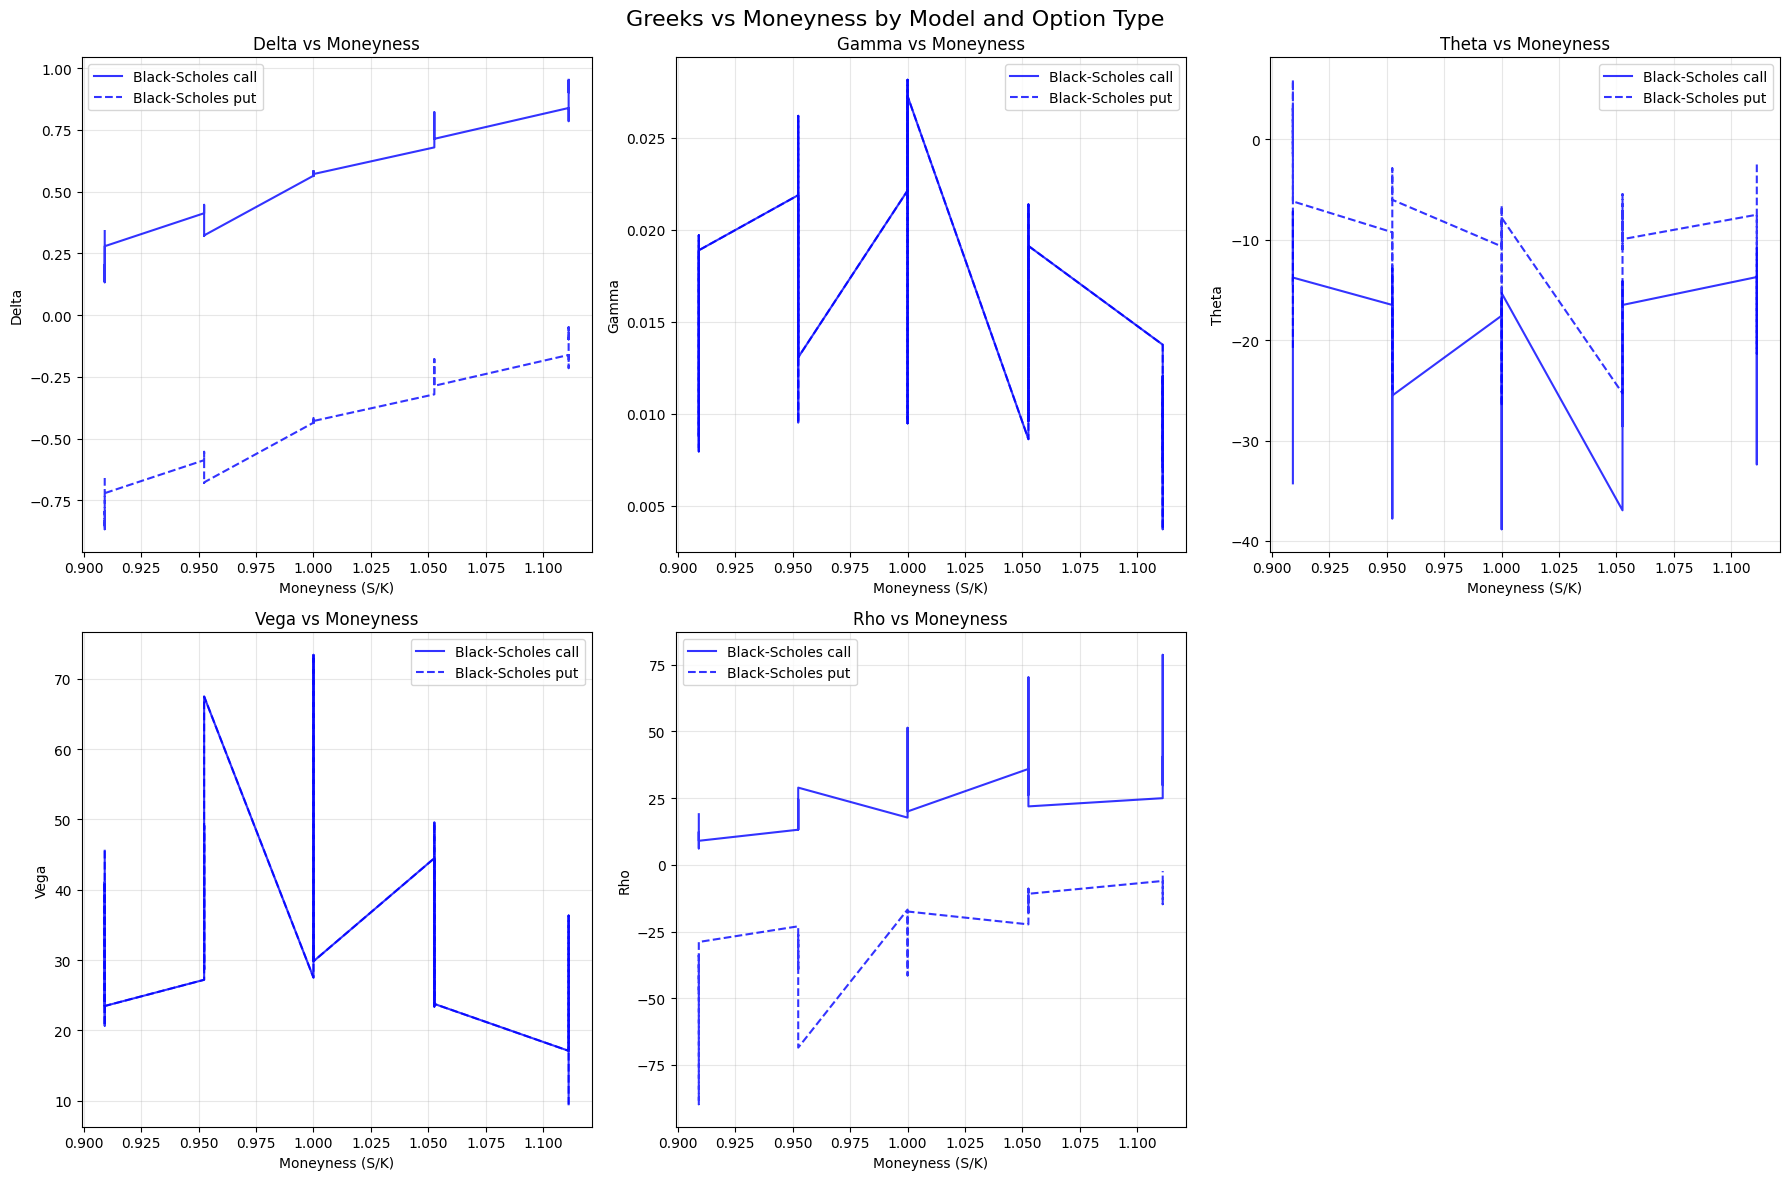

In [30]:
# Setup reports directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
reports_dir = os.path.join(project_root, "reports", "greeks_validation", timestamp)
os.makedirs(reports_dir, exist_ok=True)

print(f"Charts will be saved to: {reports_dir}")

# Function to save plots
def save_plot(fig, filename):
    """Save plot to reports directory"""
    filepath = os.path.join(reports_dir, filename)
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"✓ Saved chart: {filename}")
    plt.show()

# 1. Greeks vs Moneyness (Strike/Spot ratio)
print("\n1. Creating Greeks vs Moneyness charts...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Greeks vs Moneyness by Model and Option Type', fontsize=16)

greeks_to_plot = ['delta', 'gamma', 'theta', 'vega', 'rho']
colors = {'Black-Scholes': 'blue', 'Heston': 'red'}
styles = {'call': '-', 'put': '--'}

for i, greek in enumerate(greeks_to_plot):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    for model in ['Black-Scholes', 'Heston']:
        for option_type in ['call', 'put']:
            data = greeks_df[
                (greeks_df['model'] == model) & 
                (greeks_df['option_type'] == option_type) &
                (greeks_df['expiry'] == 0.25)  # 3-month options
            ]
            
            if len(data) > 0:
                data_sorted = data.sort_values('moneyness')
                ax.plot(data_sorted['moneyness'], data_sorted[greek], 
                       color=colors[model], linestyle=styles[option_type],
                       label=f'{model} {option_type}', alpha=0.8)
    
    ax.set_title(f'{greek.capitalize()} vs Moneyness')
    ax.set_xlabel('Moneyness (S/K)')
    ax.set_ylabel(greek.capitalize())
    ax.grid(True, alpha=0.3)
    ax.legend()

# Remove empty subplot
if len(greeks_to_plot) % 3 != 0:
    axes[1, 2].remove()

plt.tight_layout()
save_plot(fig, "greeks_vs_moneyness.png")


2. Creating Greeks vs Time to Expiry charts...


✓ Saved chart: greeks_vs_expiry.png


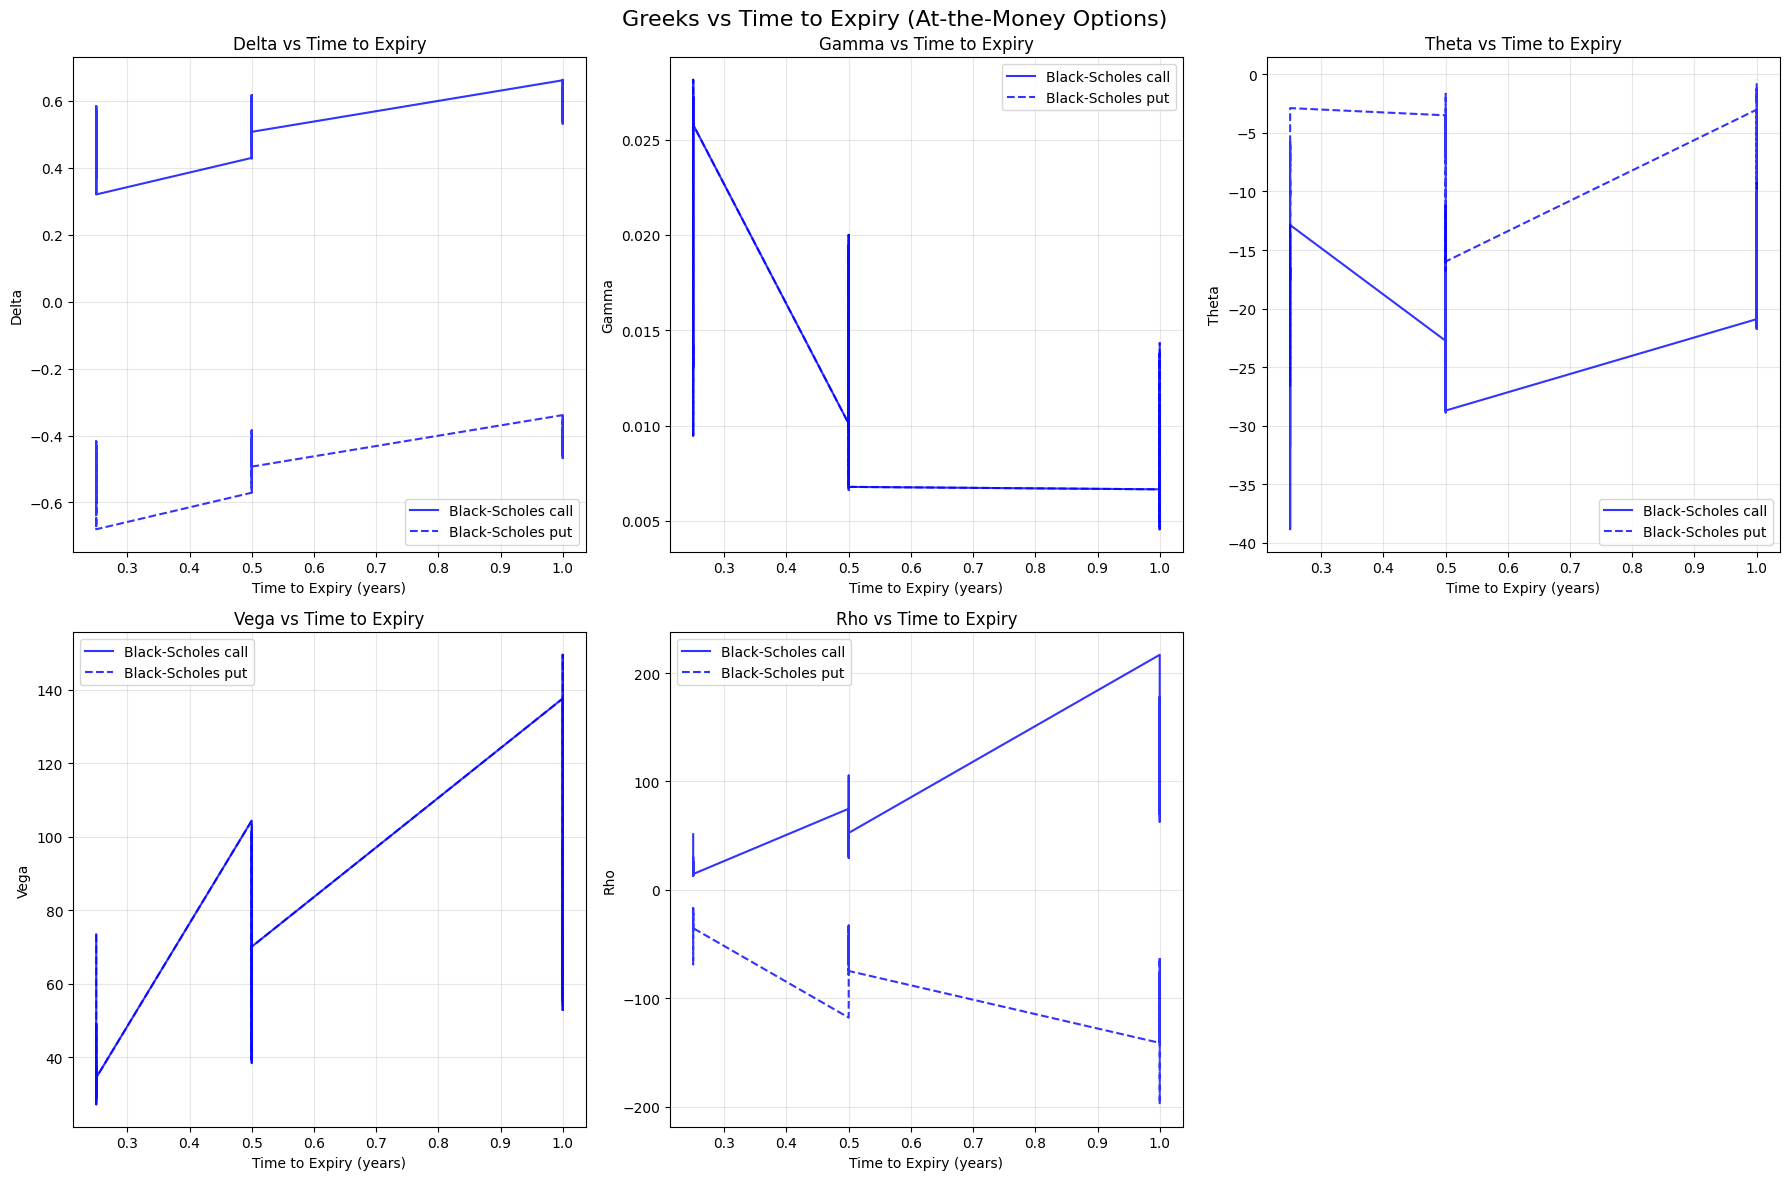

In [31]:
# 2. Greeks vs Time to Expiry
print("\n2. Creating Greeks vs Time to Expiry charts...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Greeks vs Time to Expiry (At-the-Money Options)', fontsize=16)

for i, greek in enumerate(greeks_to_plot):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    for model in ['Black-Scholes', 'Heston']:
        for option_type in ['call', 'put']:
            # At-the-money options (moneyness close to 1.0)
            data = greeks_df[
                (greeks_df['model'] == model) & 
                (greeks_df['option_type'] == option_type) &
                (abs(greeks_df['moneyness'] - 1.0) < 0.05)  # ATM +/- 5%
            ]
            
            if len(data) > 0:
                data_sorted = data.sort_values('expiry')
                ax.plot(data_sorted['expiry'], data_sorted[greek], 
                       color=colors[model], linestyle=styles[option_type],
                       label=f'{model} {option_type}', alpha=0.8)
    
    ax.set_title(f'{greek.capitalize()} vs Time to Expiry')
    ax.set_xlabel('Time to Expiry (years)')
    ax.set_ylabel(greek.capitalize())
    ax.grid(True, alpha=0.3)
    ax.legend()

# Remove empty subplot
if len(greeks_to_plot) % 3 != 0:
    axes[1, 2].remove()

plt.tight_layout()
save_plot(fig, "greeks_vs_expiry.png")


3. Creating Model Comparison Summary...
✓ Saved chart: model_comparison_summary.png
✓ Saved chart: model_comparison_summary.png


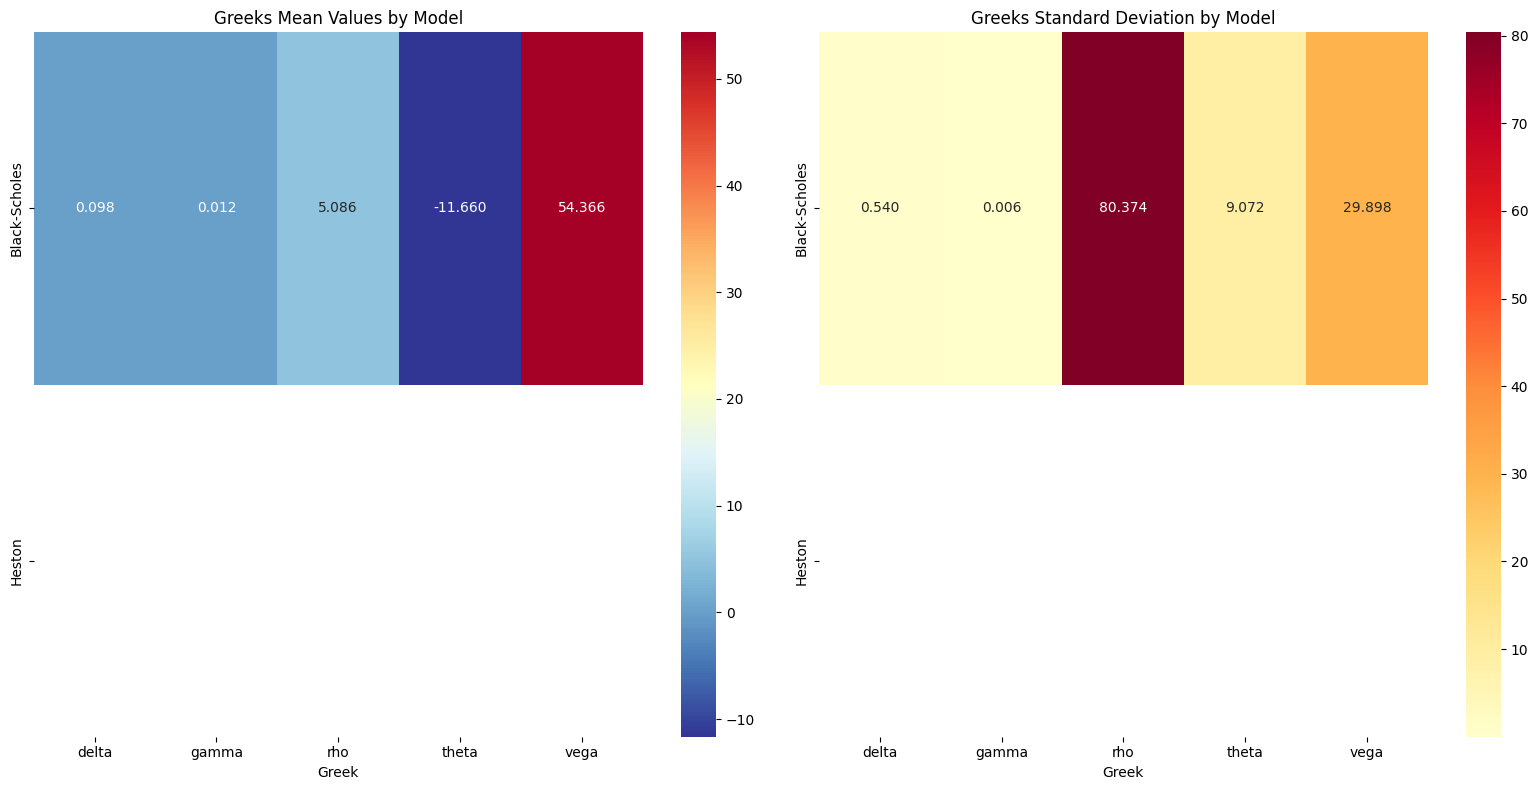


Greeks Summary Statistics:


,Model,Greek,Mean,Std,Min,Max,Count
0,Black-Scholes,delta,0.0979,0.5402,-0.8672,0.9527,150
1,Black-Scholes,gamma,0.0123,0.0060,0.0037,0.0281,150
2,Black-Scholes,theta,-11.6603,9.0716,-38.8350,5.9336,150
3,Black-Scholes,vega,54.3662,29.8980,9.4940,149.5226,150
4,Black-Scholes,rho,5.0863,80.3735,-255.4290,270.0595,150


In [32]:
# 3. Model Comparison Summary
print("\n3. Creating Model Comparison Summary...")

# Calculate summary statistics
summary_stats = []
for model in ['Black-Scholes', 'Heston']:
    for greek in ['delta', 'gamma', 'theta', 'vega', 'rho']:
        model_data = greeks_df[greeks_df['model'] == model][greek]
        if len(model_data) > 0:
            stats = {
                'Model': model,
                'Greek': greek,
                'Mean': model_data.mean(),
                'Std': model_data.std(),
                'Min': model_data.min(),
                'Max': model_data.max(),
                'Count': len(model_data)
            }
            summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)

# Create comparison heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Mean values heatmap
bs_means = summary_df[summary_df['Model'] == 'Black-Scholes'].set_index('Greek')['Mean']
heston_means = summary_df[summary_df['Model'] == 'Heston'].set_index('Greek')['Mean']
comparison_df = pd.DataFrame({'Black-Scholes': bs_means, 'Heston': heston_means})

import seaborn as sns
sns.heatmap(comparison_df.T, annot=True, fmt='.3f', ax=ax1, cmap='RdYlBu_r')
ax1.set_title('Greeks Mean Values by Model')

# Standard deviation comparison
bs_stds = summary_df[summary_df['Model'] == 'Black-Scholes'].set_index('Greek')['Std']
heston_stds = summary_df[summary_df['Model'] == 'Heston'].set_index('Greek')['Std']
std_comparison_df = pd.DataFrame({'Black-Scholes': bs_stds, 'Heston': heston_stds})

sns.heatmap(std_comparison_df.T, annot=True, fmt='.3f', ax=ax2, cmap='YlOrRd')
ax2.set_title('Greeks Standard Deviation by Model')

plt.tight_layout()
save_plot(fig, "model_comparison_summary.png")

# Display summary table
print("\nGreeks Summary Statistics:")
display(summary_df.round(4))

In [33]:
# 4. Volatility Smile Effect (Heston vs Black-Scholes)
print("\n4. Creating Volatility Smile Analysis...")

if 'Heston' in greeks_df['model'].values:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Volatility Smile Effects: Black-Scholes vs Heston', fontsize=16)
    
    # Focus on key Greeks that show volatility smile effects
    smile_greeks = ['delta', 'gamma', 'vega', 'theta']
    
    for i, greek in enumerate(smile_greeks):
        ax = axes[i//2, i%2]
        
        # Plot for calls only, 3-month expiry
        for model in ['Black-Scholes', 'Heston']:
            data = greeks_df[
                (greeks_df['model'] == model) & 
                (greeks_df['option_type'] == 'call') &
                (greeks_df['expiry'] == 0.25)
            ]
            
            if len(data) > 0:
                data_sorted = data.sort_values('moneyness')
                ax.plot(data_sorted['moneyness'], data_sorted[greek], 
                       'o-', color=colors[model], label=model, alpha=0.8)
        
        ax.set_title(f'{greek.capitalize()} - Call Options (3M)')
        ax.set_xlabel('Moneyness (S/K)')
        ax.set_ylabel(greek.capitalize())
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Add vertical line at ATM
        ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5, label='ATM')
    
    plt.tight_layout()
    save_plot(fig, "volatility_smile_effects.png")
else:
    print("Heston model results not available for volatility smile analysis")


4. Creating Volatility Smile Analysis...
Heston model results not available for volatility smile analysis


## 6. Save Processed Data and Generate Report

Final data processing and report generation for the Greeks validation analysis.

In [34]:
# Save processed Greeks data
print("Saving processed Greeks data...")

# Ensure processed data directory exists
processed_dir = os.path.join(project_root, "data", "processed")
os.makedirs(processed_dir, exist_ok=True)

# Save main Greeks dataset
greeks_file = os.path.join(processed_dir, f"greeks_validation_{timestamp}.csv")
greeks_df.to_csv(greeks_file, index=False)
print(f"✓ Saved Greeks data: {greeks_file}")

# Save summary statistics
summary_file = os.path.join(processed_dir, f"greeks_summary_{timestamp}.csv")
summary_df.to_csv(summary_file, index=False)
print(f"✓ Saved summary statistics: {summary_file}")

# Also save in reports directory
greeks_df.to_csv(os.path.join(reports_dir, "greeks_data.csv"), index=False)
summary_df.to_csv(os.path.join(reports_dir, "summary_statistics.csv"), index=False)

print(f"✓ Saved copies to reports directory: {reports_dir}")

Saving processed Greeks data...
✓ Saved Greeks data: /workspaces/Systematic-Options-Auto-Hedging-Engine/data/processed/greeks_validation_20251001_214130.csv
✓ Saved summary statistics: /workspaces/Systematic-Options-Auto-Hedging-Engine/data/processed/greeks_summary_20251001_214130.csv
✓ Saved copies to reports directory: /workspaces/Systematic-Options-Auto-Hedging-Engine/reports/greeks_validation/20251001_214130


In [35]:
# Generate analysis report
print("\nGenerating Greeks Validation Report...")

report_content = f"""
# Greeks Validation Report
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Configurations
- **Black-Scholes Parameters:**
  - Risk-free rate: {bs_params['risk_free_rate']}
  - Volatility: {bs_params['volatility']}
  - Dividend yield: {bs_params['dividend_yield']}

- **Heston Parameters:**
  - Risk-free rate: {heston_params['risk_free_rate']}
  - Initial volatility: {heston_params['initial_volatility']}
  - Long-term volatility: {heston_params['theta']}
  - Mean reversion speed: {heston_params['kappa']}
  - Volatility of volatility: {heston_params['sigma']}
  - Correlation: {heston_params['rho']}

## Data Summary
- Total calculations: {len(greeks_df):,}
- Models compared: {len(greeks_df['model'].unique())}
- Option types: {', '.join(greeks_df['option_type'].unique())}
- Strike range: {greeks_df['strike_price'].min():.0f} - {greeks_df['strike_price'].max():.0f}
- Expiry range: {greeks_df['expiry'].min():.2f} - {greeks_df['expiry'].max():.2f} years

## Key Findings
"""

# Add model comparison insights
if len(summary_df) > 0:
    report_content += "\n### Model Comparison Insights:\n"
    for greek in ['delta', 'gamma', 'theta', 'vega', 'rho']:
        bs_mean = summary_df[(summary_df['Model'] == 'Black-Scholes') & (summary_df['Greek'] == greek)]['Mean'].values
        heston_mean = summary_df[(summary_df['Model'] == 'Heston') & (summary_df['Greek'] == greek)]['Mean'].values
        
        if len(bs_mean) > 0 and len(heston_mean) > 0:
            diff_pct = ((heston_mean[0] - bs_mean[0]) / abs(bs_mean[0]) * 100) if bs_mean[0] != 0 else 0
            report_content += f"- **{greek.capitalize()}**: Heston avg = {heston_mean[0]:.4f}, BS avg = {bs_mean[0]:.4f} (diff: {diff_pct:+.1f}%)\n"

report_content += f"""

## Files Generated
- Greeks data: greeks_data.csv
- Summary statistics: summary_statistics.csv
- Charts: greeks_vs_moneyness.png, greeks_vs_expiry.png, model_comparison_summary.png, volatility_smile_effects.png

Report saved to: {reports_dir}
"""

# Save report
report_file = os.path.join(reports_dir, "analysis_report.md")
with open(report_file, 'w') as f:
    f.write(report_content)

print(f"✓ Generated analysis report: {report_file}")
print(f"\n🎯 Greeks validation analysis complete!")
print(f"📁 All results saved to: {reports_dir}")
print(f"📊 Generated {len([f for f in os.listdir(reports_dir) if f.endswith('.png')])} charts")
print(f"📈 Analyzed {len(greeks_df):,} Greek calculations")


Generating Greeks Validation Report...
✓ Generated analysis report: /workspaces/Systematic-Options-Auto-Hedging-Engine/reports/greeks_validation/20251001_214130/analysis_report.md

🎯 Greeks validation analysis complete!
📁 All results saved to: /workspaces/Systematic-Options-Auto-Hedging-Engine/reports/greeks_validation/20251001_214130
📊 Generated 3 charts
📈 Analyzed 150 Greek calculations
